In [300]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import folium
import os

In [301]:
import pyroutelib3
from pyroutelib3 import Router
import requests, json
import urllib.parse
import tempfile
import zipfile

In [302]:
import tkinter as tk
from tkinter import simpledialog
from tkinter import messagebox

# Bases de données de vélos en libre service

In [237]:
temporary_location = tempfile.gettempdir()
def download_unzip(url, dirname = tempfile.gettempdir(), destname = "borders"):
  myfile = requests.get(url)
  open(dirname + '/' + destname + '.zip', 'wb').write(myfile.content)
  with zipfile.ZipFile(dirname + '/' + destname + '.zip', 'r') as zip_ref:
      zip_ref.extractall(dirname + '/' + destname)

download_unzip('https://www.data.gouv.fr/fr/datasets/r/07b7c9a2-d1e2-4da6-9f20-01a7b72d4b12')
communes_borders = gpd.read_file(temporary_location + "/borders/communes-20190101.json")
communes_borders.head()

,insee,nom,wikipedia,surf_ha,geometry
0,97223,Saint-Esprit,fr:Saint-Esprit (Martinique),2318,"POLYGON ((-60.93595 14.58812, -60.93218 14.585..."
1,97233,Le Morne-Vert,fr:Le Morne-Vert,1325,"POLYGON ((-61.12165 14.71928, -61.11852 14.716..."
2,97208,Fonds-Saint-Denis,fr:Fonds-Saint-Denis,2374,"POLYGON ((-61.13355 14.74657, -61.13066 14.748..."
3,97224,Saint-Joseph,fr:Saint-Joseph (Martinique),4324,"POLYGON ((-61.08459 14.72510, -61.08430 14.722..."
4,97212,Gros-Morne,fr:Gros-Morne,4601,"POLYGON ((-61.08459 14.72510, -61.08061 14.725..."


## Velib - disponibilité en temps réel

Données disponibles au lien suivant : 
https://smartregionidf.opendatasoft.com/explore/dataset/velib-disponibilite-en-temps-reel/export/?disjunctive.name&disjunctive.is_installed&disjunctive.is_renting&disjunctive.is_returning&disjunctive.nom_arrondissement_communes

In [270]:
velib = gpd.read_file("https://smartregionidf.opendatasoft.com/explore/dataset/velib-disponibilite-en-temps-reel/download/?format=geojson&timezone=Europe/Berlin&lang=fr")

## Cristolib et Vélo2 en libre-service à Créteil

Données disponibles aux liens suivants : 
- https://smartregionidf.opendatasoft.com/explore/dataset/cristolib_-_velos_en_libre-service_a_creteil/information/
- https://smartregionidf.opendatasoft.com/explore/dataset/jcdecaux-bike-stations-data/information/


In [271]:
velos2 = gpd.read_file('https://smartregionidf.opendatasoft.com/explore/dataset/jcdecaux-bike-stations-data/download/?format=geojson&timezone=Europe/Berlin&lang=fr')
cristolib = gpd.read_file('https://smartregionidf.opendatasoft.com/explore/dataset/cristolib_-_velos_en_libre-service_a_creteil/download/?format=geojson&timezone=Europe/Berlin&lang=fr')

## Veligo

Données disponibles au lien suivant : https://smartregionidf.opendatasoft.com/explore/dataset/points-de-contact-veligo-location/information/

In [272]:
veligo = gpd.read_file('https://smartregionidf.opendatasoft.com/explore/dataset/points-de-contact-veligo-location/download/?format=geojson&timezone=Europe/Berlin&lang=fr')

## VélO2 et Cristolib et Vélo2 en libre-service dans le 95

Données disponibles aux liens suivants : 
- https://smartregionidf.opendatasoft.com/explore/dataset/jcdecaux-bike-stations-data/information/
- https://smartregionidf.opendatasoft.com/explore/dataset/velo2_-_cergy-pontoise_et_communes_limitrophes/information/

In [273]:
cristolib_95 = gpd.read_file('https://smartregionidf.opendatasoft.com/explore/dataset/jcdecaux-bike-stations-data/download/?format=geojson&timezone=Europe/Berlin&lang=fr')
velos2_95 = gpd.read_file('https://smartregionidf.opendatasoft.com/explore/dataset/velo2_-_cergy-pontoise_et_communes_limitrophes/download/?format=geojson&timezone=Europe/Berlin&lang=fr')

In [331]:
cristolib.head(10)

,name,geometry,type,numbikesavailable
0,09 - EUROPARC,POINT (2.47131 48.76604),cristolib,N
1,08 - ROND POINT HOTEL DE VILLE,POINT (2.45538 48.77735),cristolib,N
2,04 - UNIVERSITE - MAIL DES MECHES,POINT (2.44625 48.78811),cristolib,N
3,02 - HOPITAL INTERCOMMUNAL (CHIC),POINT (2.46371 48.79617),cristolib,N
4,01 - LATTRE DE TASSIGNY,POINT (2.45388 48.79884),cristolib,N
5,06 - AVENUE DE LA BRECHE,POINT (2.45458 48.78350),cristolib,N
6,03 - RUE DU GENERAL LECLERC - CENTRE ANCIEN,POINT (2.46489 48.79079),cristolib,N
7,05 - GENERAL LECLERC / BARRAGE,POINT (2.46857 48.78684),cristolib,N
8,07- AVENUE DU DOCTEUR PAUL CASALIS,POINT (2.46969 48.78021),cristolib,N
9,10 - MAGELLAN,POINT (2.45666 48.76896),cristolib,N


In [329]:
cristolib.shape

(10, 4)

In [332]:
velos2.head(10)

,name,geometry,type,numbikesavailable
0,08 - ROND POINT HOTEL DE VILLE,POINT (2.45538 48.77735),velos2,15
1,07- AVENUE DU DOCTEUR PAUL CASALIS,POINT (2.46969 48.78021),velos2,2
2,50017 - CER17 - CERGY VILLAGE CENTRE,POINT (2.06192 49.03551),velos2,5
3,05 - GENERAL LECLERC / BARRAGE,POINT (2.46857 48.78684),velos2,3
4,50025 - CER25 - ARENICE,POINT (2.05732 49.05099),velos2,4
5,50003 - CER03 - LES ESSARTS (CB),POINT (2.01958 49.04232),velos2,2
6,50012 - CER12 - PLACE DU HAUT-GENCY,POINT (2.04512 49.04659),velos2,6
7,50021 - CER21 - DALLE PIÉTONNE GRAND CENTRE,POINT (2.07957 49.03632),velos2,18
8,01 - LATTRE DE TASSIGNY,POINT (2.45388 48.79884),velos2,10
9,10 - MAGELLAN,POINT (2.45666 48.76896),velos2,6


In [330]:
velos2.shape

(53, 4)

In [39]:
#Ajout d'une colonne correspondant au type du vélo (vélib, véligo, cristolib ou vélos2)

velib["type"]=["velib" for i in range(velib.shape[0])]
veligo["type"]=["veligo" for i in range(veligo.shape[0])]
velos2["type"]=["velos2" for i in range(velos2.shape[0])]
cristolib["type"]=["cristolib" for i in range(cristolib.shape[0])]
velos2_95["type"]=["velos2_95" for i in range(velos2_95.shape[0])]
cristolib_95["type"]=["cristolib_95" for i in range(cristolib_95.shape[0])]

## Fusion des bases de données Vélib, Veligo, Cristolib, Velos2

In [275]:
# Ajout d'une colonne correspondant au type de vélo emprunté (velib, veligo, cristolib ou velos2)

velib["type"]=["velib" for i in range(velib.shape[0])]
veligo["type"]=["veligo" for i in range(veligo.shape[0])]
velos2["type"]=["velos2" for i in range(velos2.shape[0])]
cristolib["type"]=["cristolib" for i in range(cristolib.shape[0])]
velos2_95["type"]=["velos2" for i in range(velos2_95.shape[0])]
cristolib_95["type"]=["cristolib" for i in range(cristolib_95.shape[0])]

# Ajout d'une colonne disponibilité vélos pour ceux qui n'en ont pas

velos2_95["numbikesavailable"]=["N" for i in range(velos2_95.shape[0])]
cristolib["numbikesavailable"]=["N" for i in range(cristolib.shape[0])]
veligo["numbikesavailable"]=["N" for i in range(veligo.shape[0])]

# Reset les index

#velos2.set_index(['name', 'geometry', "type", "available_bikes"])

In [276]:
# Selectionner et renommer les colonnes de chaque base

velib = velib[["name","geometry","type", "numbikesavailable"]]

veligo = veligo [["nom","geometry","type","numbikesavailable"]]
veligo.columns = ['name','geometry',"type","numbikesavailable"]


In [277]:
velos2 = velos2 [["name", "geometry","type","available_bikes"]]
velos2.columns = ['name','geometry',"type","numbikesavailable"]

cristolib = cristolib [["name", "geometry","type","numbikesavailable"]]

velos2_95 = velos2 [["name", "geometry", "type","numbikesavailable"]]

cristolib_95 = cristolib_95 [["name", "geometry","type","available_bikes"]]
cristolib_95.columns = ['name','geometry',"type","numbikesavailable"]

In [278]:
velos = pd.concat([veligo, velib, velos2, cristolib, velos2_95, cristolib_95], ignore_index=True)

In [279]:
velos.shape

(2646, 4)

In [280]:
velos.shape[0] ==  veligo.shape[0] + velib.shape[0] + velos2.shape[0] + cristolib.shape[0] + velos2_95.shape[0] + cristolib_95.shape[0]

True

In [281]:
velos

,name,geometry,type,numbikesavailable
0,ST MAUR DES FOSSES PDC,POINT (2.49129 48.80253),veligo,N
1,BRY PPDC1,POINT (2.52455 48.82955),veligo,N
2,CRETEIL PPDC1,POINT (2.45490 48.77790),veligo,N
3,FONTENAY SOUS BOIS PDC1,POINT (2.47531 48.84936),veligo,N
4,IVRY PDC1,POINT (2.40150 48.80670),veligo,N
...,...,...,...,...
2641,50014 - CER14 - AVENUE DU NORD,POINT (2.06040 49.04322),cristolib,8
2642,50005 - CER05 - MOULIN A VENT,POINT (2.01708 49.04940),cristolib,3
2643,54901 - VAU01 - PLACE DU RDV (CB),POINT (2.02031 49.03293),cristolib,5
2644,06 - AVENUE DE LA BRECHE,POINT (2.45458 48.78350),cristolib,3


In [282]:
data_borders = communes_borders.set_index('insee')
data_borders['dep'] = data_borders.index.str[:2]
departements = gpd.read_file('https://www.data.gouv.fr/fr/datasets/r/ec305e78-f231-4a77-b32c-1e0c4c67615e')
dpt = departements[departements['code_departement'].isin(['75', '77', '78', '91', '92', '93', '94', '95' ])]

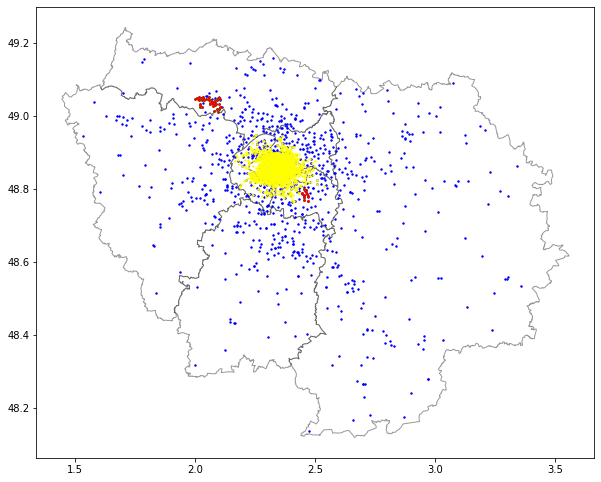

In [319]:
fig, ax = plt.subplots(figsize = (10,10))
#data_borders.loc[data_borders['dep'].isin(['75','77', '78', '91','92','93','94', '95'])].plot(ax=ax, color='0.8', edgecolor='black')
dpt.plot(ax=ax, color = 'white', edgecolor = 'black', alpha = 0.4)


velos[velos["type"]=="veligo"].plot(ax=ax, color='blue', markersize=2)
velos[velos["type"]=="velib"].plot(ax=ax, color='yellow', markersize=2)
#velos[velos["type"]=="velos2"].plot(ax=ax, color='green', markersize=2)
velos[velos["type"]=="cristolib"].plot(ax=ax, color='red', markersize=2)

plt.show()

In [317]:
centre = [48.8534 , 2.3488] #le centre de paris 
idf = folium.Map(location = centre, zoom_start = 11)
idf

# Choix du point de départ et du point d'arrivée

In [340]:
adresse_depart =input("D'où partez-vous ? (numéro, rue, code postal ville)")

adresse_arrivee = input("Où voulez-vous aller ? (numéro, rue, code postal ville)")

D'où partez-vous ? (numéro, rue, code postal ville) 57, avenue du Plessis, 92350
Où voulez-vous aller ? (numéro, rue, code postal ville) 3, avenue de Verdun, 92120 Montrouge


In [ ]:
print(adresse_depart)

In [310]:
print(adresse_arrivee)

3, avenue de Verdun, 92120 Montrouge


In [341]:
#adresse_depart = "5, Avenue Anatole France, 75007 Paris"
#adresse_arrivee = "35, Rue du Chevalier de la Barre, 75018 Paris"
dep_json = requests.get("https://api-adresse.data.gouv.fr/search/?q=" + urllib.parse.quote(adresse_depart) + "&format=json").json()
arr_json = requests.get("https://api-adresse.data.gouv.fr/search/?q=" + urllib.parse.quote(adresse_arrivee) + "&format=json").json()
coord_dep = list(dep_json['features'][0].get('geometry').get('coordinates'))
coord_arr = list(arr_json['features'][0].get('geometry').get('coordinates'))
#coord_dep
#coord_arr

In [342]:
x = input("Avez-vous votre propre vélo ? Entrez 'oui' ou 'non' ")

Avez-vous votre propre vélo ? Entrez 'oui' ou 'non'  non


## Lorsque l'utilisateur n'a pas son propre vélo

In [343]:
if(x=='non'):
    # Calcul de la distance en km entre le point de départ et toutes les stations

    distances = []
    for i in range(len(velos.geometry)):
      a = (max(velos.geometry[i].x, coord_dep[0]) - min(velos.geometry[i].x, coord_dep[0]))**2 + (max(velos.geometry[i].y, coord_dep[1]) - min(velos.geometry[i].y, coord_dep[1]))**2
      a = a**(1/2)*100
      distances.append(a)
    
    #Station la plus proche du point de départ 

    i = distances.index(min(distances))

    station_dep = [velos["geometry"][i].y, velos["geometry"][i].x]

    print( 'Station la plus proche du point de départ : \n', velos["name"][i] )
    
    # Vérification disponibilité vélo dans la station de départ
    
    if(velos["numbikesavailable"][i]!=0 and velos["numbikesavailable"][i]!="N" ):
        print("\n \n Un vélo est disponible à la station la plus proche du point de départ")
        
    #if(velos["numbikesavailable"][i]=="N" ):
    #    print("\n \n Nous ne disposons pas d'information concernant la disponibilité d'un vélo à la station la plus proche du point de départ")
        
    print('\n \nDistance à effectuer à pied (point d arrivee -> station) :', min(distances), "km")
    print("soit un temps de trajet d'environ:", min(distances)*1000/66.67, "minutes\n \n")
    
    # Calcul de la distance en km entre le point d'arrivée et toutes les stations

    distances = []
    for i in range(len(velos.geometry)):
      a = (max(velos.geometry[i].x, coord_arr[0]) - min(velos.geometry[i].x, coord_arr[0]))**2 + (max(velos.geometry[i].y, coord_arr[1]) - min(velos.geometry[i].y, coord_arr[1]))**2
      a = a**(1/2)*100
      distances.append(a)
    
    #Station la plus proche du point d'arrivée

    j = distances.index(min(distances))

    station_arr = [velos["geometry"][j].y, velos["geometry"][j].x] 

    print( 'Station la plus proche du point d arrivée: \n', velos["name"][j] )
    print( '\n \nDistance à effectuer à pied (station -> point d arrivee) :', min(distances), "km")
    print("soit un temps de trajet d'environ:", min(distances)*1000/66.67, "minutes\n \n")
    
    
    #Trajet à pied : point de départ -> station départ
    
    coor_depart = [coord_dep[1], coord_dep[0]] 
    coor_arrivee = [coord_arr[1], coord_arr[0]] 

    folium.Marker(coor_depart,popup="Départ").add_to(idf)
    folium.Marker(coor_arrivee,popup="Arrivée").add_to(idf)
    
    router = pyroutelib3.Router("foot")

    depart = router.findNode(coor_depart[0], coor_depart[1])
    arrivee = router.findNode(station_dep[0], station_dep[1])

    routeLatLons=[coor_depart,station_dep]
    status, route = router.doRoute(depart, arrivee)
    if status == 'success':
      #print("votre trajet existe")
      routeLatLons = list(map(router.nodeLatLon, route))
    else:
      print("Votre trajet n'existe pas")

    #print(routeLatLons)
    for coord in routeLatLons:
      coord=list(coord)
      folium.CircleMarker(coord,radius = 3,fill=True, color='green').add_to(idf)

    folium.PolyLine(routeLatLons, color="black", weight=2.5, opacity=1).add_to(idf)
    
    # Trajet en vélo : station départ -> station arrivée
    
    router = pyroutelib3.Router("cycle")
    depart = router.findNode(station_dep[0], station_dep[1])
    arrivee = router.findNode(station_arr[0], station_arr[1])

    routeLatLons=[station_dep,station_arr]
    status, route = router.doRoute(depart, arrivee)
    if status == 'success':
      #print("votre trajet existe")
      routeLatLons = list(map(router.nodeLatLon, route))
    else:
      print("votre trajet n'existe pas")

    #print(routeLatLons)
    for coord in routeLatLons:
      coord=list(coord)
      folium.CircleMarker(coord,radius = 3,fill=True, color='green').add_to(idf)

    folium.PolyLine(routeLatLons, color="red", weight=2.5, opacity=1).add_to(idf)
    
    
    # Trajet à pied : station arrivée -> point d'arrivée
    
    router = pyroutelib3.Router("foot")
    depart = router.findNode(station_arr[0], station_arr[1])
    arrivee = router.findNode(coor_arrivee[0], coor_arrivee[1])

    routeLatLons=[station_arr, coor_arrivee]
    status, route = router.doRoute(depart, arrivee)
    if status == 'success':
      #print("votre trajet existe")
      routeLatLons = list(map(router.nodeLatLon, route))
    else:
      print("Votre trajet n'existe pas")

    for coord in routeLatLons:
      coord=list(coord)
      folium.CircleMarker(coord,radius = 3,fill=True, color='green').add_to(idf)

    folium.PolyLine(routeLatLons, color="black", weight=2.5, opacity=1).add_to(idf)
    

Station la plus proche du point de départ : 
 Gare de Robinson

 
 Un vélo est disponible à la station la plus proche du point de départ

 
Distance à effectuer à pied (point d arrivee -> station) : 0.42876317497965233 km
soit un temps de trajet d'environ: 6.431126068391365 minutes
 

Station la plus proche du point d arrivée: 
 Molière - République

 
Distance à effectuer à pied (station -> point d arrivee) : 0.17226361742954557 km
soit un temps de trajet d'environ: 2.583825070189674 minutes
 



In [344]:
idf

# Lorsque l'utilisateur a son propre vélo

In [312]:
x='oui'

In [313]:
if(x=='oui'):
    
    coor_depart = [coord_dep[1], coord_dep[0]] 
    coor_arrivee = [coord_arr[1], coord_arr[0]] 

    folium.Marker(coor_depart,popup="Départ").add_to(idf)
    folium.Marker(coor_arrivee,popup="Arrivée").add_to(idf)
    
    # Trajet en vélo : point départ -> point d'arrivée
    
    router = pyroutelib3.Router("cycle")
    depart = router.findNode(coor_depart[0], coor_depart[1])
    #print(depart)
    arrivee = router.findNode(coor_arrivee[0], coor_arrivee[1])
    #print(arrivee)

    routeLatLons=[coor_depart,coor_arrivee]
    status, route = router.doRoute(depart, arrivee)
    if status == 'success':
      #print("Votre trajet existe")
      routeLatLons = list(map(router.nodeLatLon, route))
    else:
      print("Votre trajet n'existe pas")

    #print(routeLatLons)
    for coord in routeLatLons:
      coord=list(coord)
      folium.CircleMarker(coord,radius = 3,fill=True, color='green').add_to(idf)

    folium.PolyLine(routeLatLons, color="red", weight=2.5, opacity=1).add_to(idf)
    

In [314]:
idf

# Signalement de la part de l'utilisateur après le trajet

In [345]:
a=input("Suite à votre trajet, souhaitez-vous signaler quelque chose ? Entrez 'oui' ou 'non'")

if(a=='oui'):
    x=input("Que souhaitez-vous signaler ?")
    print("Cliquez à l'endroit correspondant sur la carte")
    
print("Merci de contribuer à l'amélioration notre application!")

idf.add_child(folium.ClickForMarker(popup=x))

#idf.add_child(folium.LatLngPopup())

Suite à votre trajet, souhaitez-vous signaler quelque chose ? Entrez 'oui' ou 'non' oui
Que souhaitez-vous signaler ? accident


Cliquez à l'endroit correspondant sur la carte
Merci de contribuer à l'amélioration notre application!
